In [1]:
# dont ask me, and I won't clean it..
import numpy as np
import glob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
%tensorflow_version 1.x
from PIL import Image
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import plot_model  #plotting the model structure
from keras import callbacks
from datetime import datetime
import os
import cv2
import string
import numpy as np


from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
! wget "https://ndownloader.figshare.com/files/22134816" -O railway_captcha5.tar.gz

--2020-03-30 09:05:35--  https://ndownloader.figshare.com/files/22134816
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 63.33.146.135, 18.203.214.185, 54.229.26.46, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|63.33.146.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22134816/railway_captcha5.tar.gz [following]
--2020-03-30 09:05:37--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22134816/railway_captcha5.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.112.115
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.112.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278587793 (266M) [application/gzip]
Saving to: ‘railway_captcha5.tar.gz’

railway_captcha5.ta 100%[===================>] 265.68M  12.0MB/s    in 24s     

2020-03-30 09:06:02 (11.1 MB/s) - ‘railway_capt

In [3]:
!tar -xvf railway_captcha5.tar.gz > /dev/null
! echo "Untaring... done..."

Untaring... done...


In [4]:
png_files = glob.glob('railway_captcha5/*.jpg')
print("Total # of files => ",len(png_files))
png_files[0]

Total # of files =>  100000


'railway_captcha5/69926_70564.jpg'

In [5]:
symbols = "ABCDEFGHJKLMNPQRSTUVWXYZ" + '0123456789' # These are all symbols the captchas will have
num_symbols = len(symbols)
img = np.array(Image.open(png_files[0]))
shape_ = img.shape
print(shape_, num_symbols)

(60, 200, 3) 34


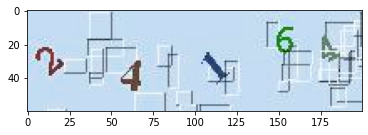

In [6]:
img_path = png_files[1]
img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()

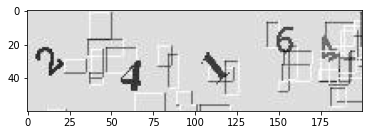

(60, 200)


In [7]:
img_path = png_files[1]
img_gray = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray,cmap='gray')
plt.show()
print(img_gray.shape)

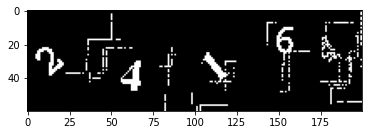

(60, 200)


In [8]:
# perform OTSU's thresholding
ret,thresh = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='gray')
plt.show()
print(thresh.shape)

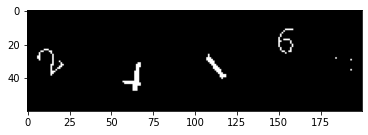

In [9]:
kernel = np.ones((2,2),np.uint8)
#dialate = cv2.dilate(thresh,kernel,iterations = 1)
erosion = cv2.erode(thresh,kernel,iterations = 1)
plt.imshow(erosion,cmap='gray')
plt.show()

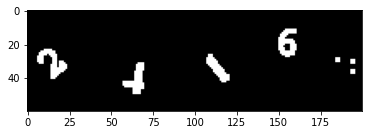

In [10]:
#kernel = np.ones((2,2),np.uint8)
dialate = cv2.dilate(erosion,kernel,iterations = 2)
#erosion = cv2.erode(thresh,kernel,iterations = 1)
plt.imshow(dialate,cmap='gray')
plt.show()

In [0]:
def create_model():
  in_ = Input(shape=img_shape)
  out = in_
  out = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Flatten()(out)
  out = Dropout(0.3)(out)
  out = [Dense(34, name='digit1', activation='softmax')(out),\
      Dense(34, name='digit2', activation='softmax')(out),\
      Dense(34, name='digit3', activation='softmax')(out),\
      Dense(34, name='digit4', activation='softmax')(out),\
      Dense(34, name='digit5', activation='softmax')(out)]
  model = Model(inputs=in_, outputs=out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [12]:
from tqdm import tqdm
kernel = np.ones((2,2),np.uint8)
letters_in_captcha = 5
def preprocess_data():
  n_samples = len(os.listdir('railway_captcha5/'))
  X = np.zeros((n_samples, 200, 60, 1)) #1070*50*200
  print(num_symbols,n_samples)
  y = np.zeros((letters_in_captcha, n_samples, num_symbols)) #5*1070*36
  for i, pic in tqdm(enumerate(os.listdir('railway_captcha5/'))):
    # Read image as grayscale
    img = cv2.imread(os.path.join('railway_captcha5/', pic), cv2.IMREAD_GRAYSCALE)
    #img = cv2.resize(img, (200,60), interpolation = cv2.INTER_AREA)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    # firstly perform erosion
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    # perform dialation
    dialate = cv2.dilate(erosion,kernel,iterations = 1)
    img = dialate.copy()
    pic_target = pic.split('_')[0]
    # plt.imshow(img,cmap='gray')
    # plt.show()
    # break
    # if len(pic_target) < 5:
    # Scale and reshape image
    #print("?")
    img = img / 255.0
    #plt.imshow(img,cmap='gray')
    img = np.reshape(img, (200, 60, 1))
    # Define targets and code them using OneHotEncoding
    targs = np.zeros((letters_in_captcha, num_symbols))
    #print("num symbols = ",num_symbols)
    for j, l in enumerate(pic_target):
      ind = symbols.find(l)
      targs[j, ind] = 1
    X[i] = img
    y[:, i] = targs
    
  # Return final data
  return X, y

X, y = preprocess_data()

0it [00:00, ?it/s]

34 100000


100000it [00:20, 4931.69it/s]


In [13]:
#print(X[0])
print(X[0].shape)
#print(y[0])
print(y[0].shape)

(200, 60, 1)
(100000, 34)


In [0]:
X_train, y_train = X[:90000], y[:, :90000]
X_test, y_test = X[90000:], y[:, 90000:]

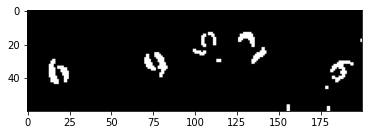

(200, 60, 1)


In [15]:
plt.imshow(X_train[0].reshape((60,200)),cmap='gray')
plt.show()
print(X_train[0].shape)

In [16]:
print(X_train.shape)

(90000, 200, 60, 1)


In [17]:
img_shape = (200, 60, 1)
model=create_model();
model.summary();













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 60, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 60, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 198, 58, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 58, 32)  128      

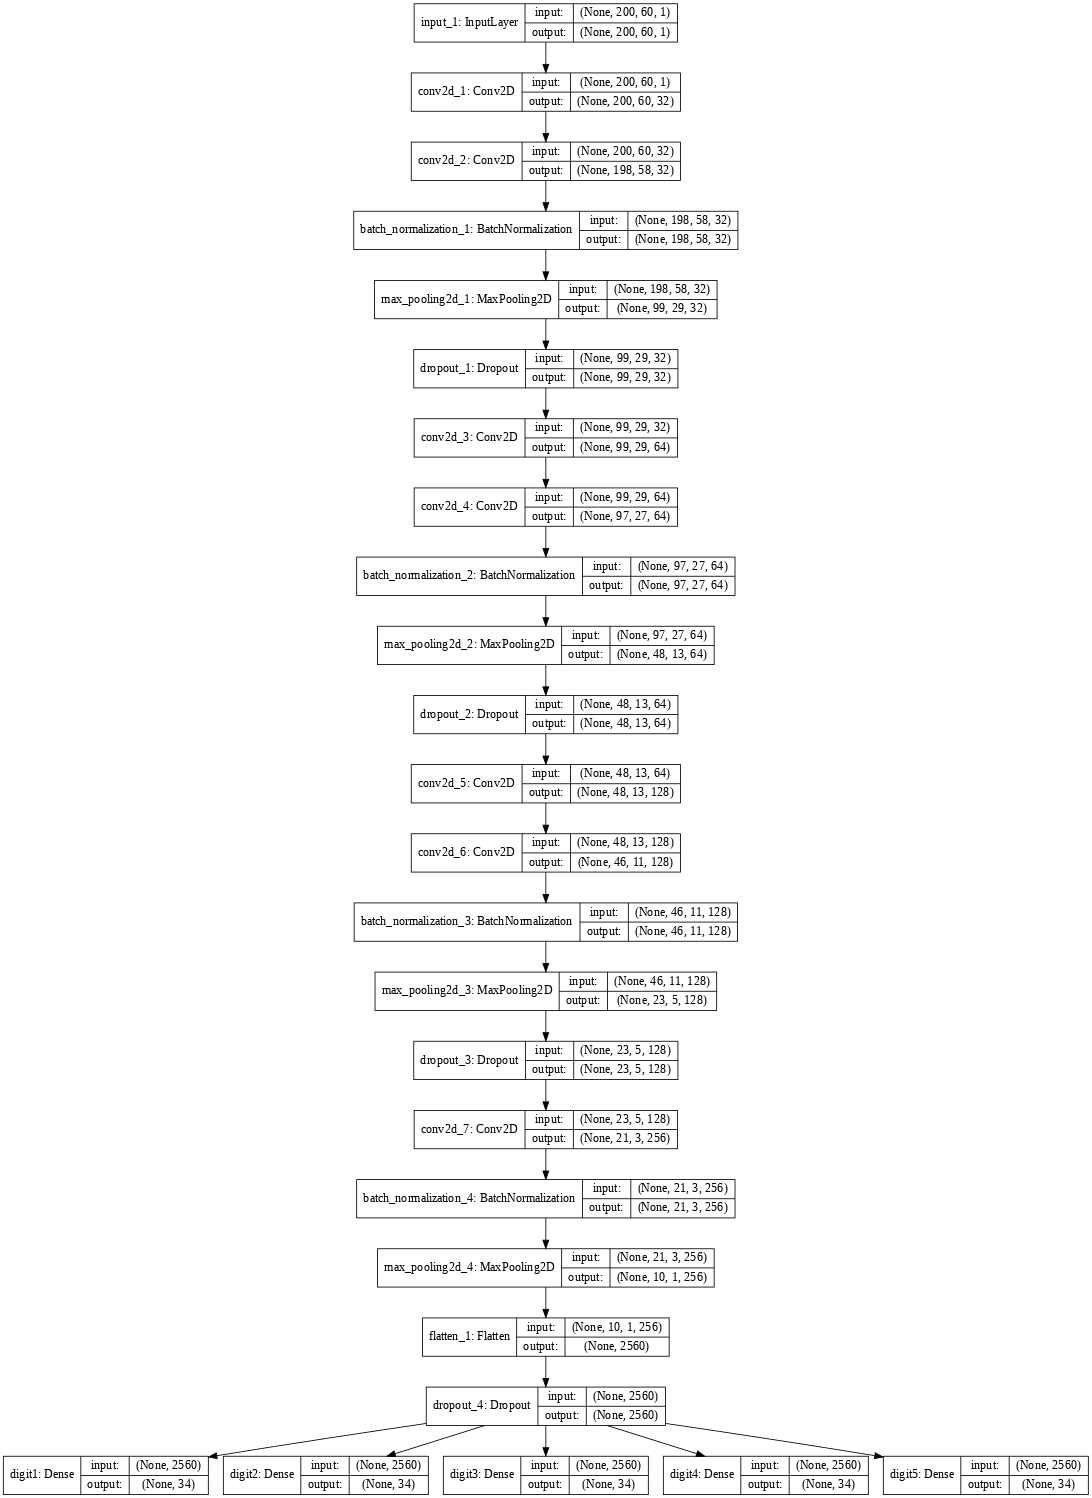

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [0]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2],y_train[3],y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2,callbacks=[tensorboard_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 72000 samples, validate on 18000 samples
Epoch 1/30
72000/72000 [==============================] - 91s 1ms/step - loss: 13.4705 - digit1_loss: 2.7035 - digit2_loss: 2.6882 - digit3_loss: 2.6892 - digit4_loss: 2.6932 - digit5_loss: 2.6964 - digit1_acc: 0.1156 - digit2_acc: 0.1164 - digit3_acc: 0.1161 - digit4_acc: 0.1171 - digit5_acc: 0.1161 - val_loss: 13.7130 - val_digit1_loss: 2.6997 - val_digit2_loss: 2.7712 - val_digit3_loss: 2.7130 - val_digit4_loss: 2.7680 - val_digit5_loss: 2.7610 - val_digit1_acc: 0.1036 - val_digit2_acc: 0.1074 - val_digit3_acc: 0.1012 - val_digit4_acc: 0.1083 - val_digit5_acc: 0.0949
Epoch 2/30
72000/72000 [==============================] - 82s 1ms/step - loss: 11.5482 - digit1_loss: 2.2913 - digit2_loss: 2.3060 - digit3_loss: 2.3233 - digit4_loss: 2.3171 - digit5_loss: 2.3104 - digit1_acc: 0.2159 - digit2_acc: 0.2113 - digit3_acc: 0.2052 - digit4_acc: 0.2

In [0]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [0]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    # firstly perform erosion
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    # perform dialation
    dialate = cv2.dilate(erosion,kernel,iterations = 1)
    img = dialate.copy()
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    #res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    new_im = img.reshape((img.shape[1],img.shape[0]))
    res = np.array(model.predict(new_im[np.newaxis,:,:,np.newaxis]))
    #print(res)
    ans = np.reshape(res, (3, 34))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [0]:
total_img = 36
num_pr = 6 # number per row

counter = 1
plt.figure(figsize=(30,15))
plt.axis('off')
for item in png_files[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  pred = predict(item)
  #print(pred)
  image_bckup = image.copy()
  plt.subplot(num_pr, num_pr, counter)
  #print("item => ",item)
  #print("item => ",str(item.split('_')[1]).split('/')[1])
  if str(item.split('_')[1]).split('/')[1] == str(pred):
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('green')
  else:
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('red')
  plt.axis('off')
  plt.imshow(image_bckup, cmap=plt.get_cmap('gray'))
  counter += 1
  #break
plt.show()

In [0]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2],y_test[3],y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2],y_test[3],y_test[4]])

In [0]:
num_viz = 10
for item in png_files[:num_viz]:
  # image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  # image_bckup = image.copy()
  # image = image[np.newaxis,:, :, np.newaxis]/255.0
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  pred = predict(item)
  print(pred)

In [0]:
# download the model in computer for later use

model.save('railway_captcha_5_imop.h5')
# download the model from colab
from google.colab import files
files.download('railway_captcha_5_imop.h5')